In [1]:
import matplotlib.pyplot as plt
import nb_utils
import numpy as np
from gtda.diagrams import Amplitude, NumberOfPoints, PersistenceEntropy, Scaler
from gtda.homology import VietorisRipsPersistence
from gtda.metaestimators import CollectionTransformer
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from src import acf_utils, sim


def get_accuracy(model, X_train, X_valid, y_train, y_valid):
    """returns the 1) classification accuracy and 2) area under ROC"""
    return (
        f"Accuracy on train: {accuracy_score(model.predict(X_train), y_train):.3f}",
        f"ROC AUC on train: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]):.3f}",
        f"Accuracy on valid: {accuracy_score(model.predict(X_valid), y_valid):.3f}",
        f"ROC AUC on valid: {roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]):.3f}",
    )


def plot_classification(model, Xs, phis):
    ys_pred = model.predict(Xs)
    fig, ax = plt.subplots()
    nb_utils.plot_stationarity_triangle(ax=ax)
    ax.scatter(
        phis[ys_pred == 0, 0],
        phis[ys_pred == 0, 1],
        s=5,
        alpha=0.25,
        label="classifier: aperiodic",
    )
    ax.scatter(
        phis[ys_pred == 1, 0],
        phis[ys_pred == 1, 1],
        s=5,
        alpha=0.25,
        label="classifier: periodic",
    )
    ax.legend()

### $\rho_k$: sublevel set filtration

('Accuracy on train: 0.875', 'ROC AUC on train: 0.889', 'Accuracy on valid: 0.885', 'ROC AUC on valid: 0.907')


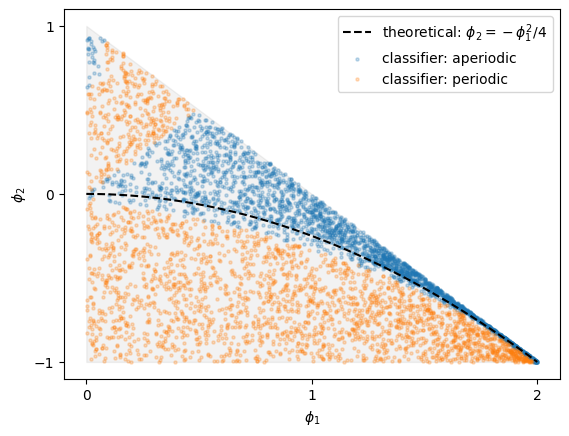

In [2]:
def sim_xy(idx, n_lags, features):
    """returns persistence entropy from sublevel set filtration of acf"""
    y = idx % 2
    phis = nb_utils.gen_ar2_coeffs(oscillatory=y, phi1="positive", random_seed=idx)
    x_acf = acf_utils.ar_to_acf(phis, n_lags=n_lags)  # theoretical acf
    x_acf_ssf = nb_utils.sublevel_set_filtration(x_acf)  # sublevel-set filtration -> PH
    x_acf_ft = features.fit_transform(x_acf_ssf)
    return phis, x_acf_ft.squeeze(), y


n_lags, n_repeats = 50, 5000  # simulation settings
features = FeatureUnion(
    [("nop", NumberOfPoints()), ("pe", PersistenceEntropy()), ("amp", Amplitude())]
)
model = LogisticRegression()  # classification settings

phis, Xs, ys = zip(*[(sim_xy(idx, n_lags, features)) for idx in range(n_repeats)])
phis, Xs, ys = np.array(phis), np.array(Xs), np.array(ys)

# fit classifier
X_train, X_valid, y_train, y_valid = train_test_split(Xs, ys, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

# classifier metrics
print(get_accuracy(model, X_train, X_valid, y_train, y_valid))
plot_classification(model, Xs, phis)

### $\rho_k$: Taken's embedding

('Accuracy on train: 0.903', 'ROC AUC on train: 0.964', 'Accuracy on valid: 0.909', 'ROC AUC on valid: 0.971')


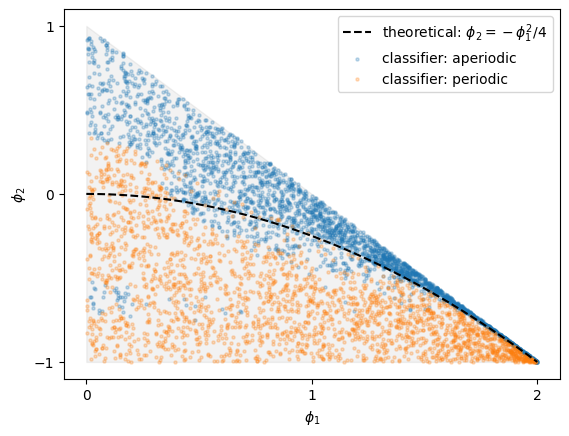

In [3]:
def sim_xy(idx, n_lags):
    """return persistence entropy from takens embedding of acf"""
    y = idx % 2
    phis = nb_utils.gen_ar2_coeffs(oscillatory=y, phi1="positive", random_seed=idx)
    x_acf = acf_utils.ar_to_acf(phis, n_lags=n_lags)  # theoretical acf
    return phis, x_acf, y


n_jobs = -1
pipeline = Pipeline(
    [
        ("emb", TakensEmbedding(time_delay=1, dimension=2)),
        ("pca", CollectionTransformer(PCA(n_components=2), n_jobs=n_jobs)),
        ("vr", VietorisRipsPersistence(homology_dimensions=(0, 1), n_jobs=n_jobs)),
        ("scaler", Scaler(metric="bottleneck")),
        ("features", features),
    ]
)


phis, Xs_acf, ys = zip(*[(sim_xy(idx, n_lags)) for idx in range(n_repeats)])
phis, Xs_acf, ys = np.array(phis), np.array(Xs_acf), np.array(ys)
Xs = pipeline.fit_transform(Xs_acf)

# fit classifier
X_train, X_valid, y_train, y_valid = train_test_split(Xs, ys, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

# classifier metrics
print(get_accuracy(model, X_train, X_valid, y_train, y_valid))
plot_classification(model, Xs, phis)

### $x_t$: Taken's embedding

('Accuracy on train: 0.618', 'ROC AUC on train: 0.664', 'Accuracy on valid: 0.611', 'ROC AUC on valid: 0.664')


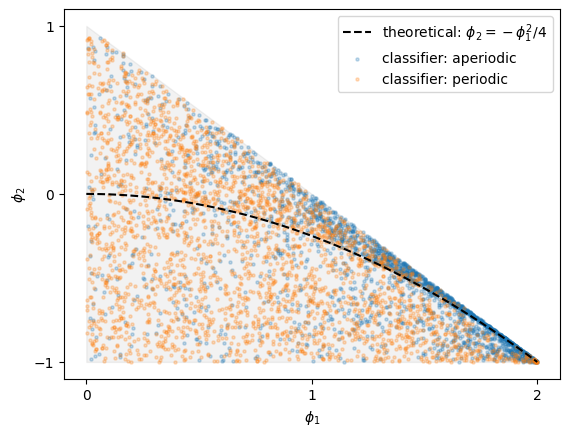

In [4]:
def sim_xy(idx, n_timepoints):
    """return persistence entropy from takens embedding of timeseries"""
    y = idx % 2
    phis = nb_utils.gen_ar2_coeffs(oscillatory=y, phi1="positive", random_seed=idx)
    x = sim.sim_ar(phis, n_timepoints, random_seed=idx).squeeze()
    return phis, x, y


n_timepoints = 250

phis, Xs_ts, ys = zip(*[(sim_xy(idx, n_timepoints)) for idx in range(n_repeats)])
phis, Xs_ts, ys = np.array(phis), np.array(Xs_ts), np.array(ys)
Xs = pipeline.fit_transform(Xs_ts)


# fit classifier
X_train, X_valid, y_train, y_valid = train_test_split(Xs, ys, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

# classifier metrics
print(get_accuracy(model, X_train, X_valid, y_train, y_valid))
plot_classification(model, Xs, phis)